In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import tensorflow as tf
import os, glob
from natsort import natsorted
from tensorflow.keras.preprocessing.image import load_img
import cv2
from tensorflow.keras.utils import image_dataset_from_directory
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# Load data into generator

In [159]:
data_dir = '../data/train'
data_dir = pathlib.Path(data_dir)

data_val_dir = '../data/val'
data_val_dir = pathlib.Path(data_val_dir)

data_test_dir = '../data/test'
data_test_dir = pathlib.Path(data_test_dir)

### Load labels

In [156]:
df_labels = pd.read_csv('../data/labels.txt', header = None, names = ['id', 'class', 'x', 'y', 'w', 'h'])
df_val_labels = pd.read_csv('../data/val_labels.txt', header = None, names = ['id', 'class', 'x', 'y', 'w', 'h'])
df_train_labels = pd.read_csv('../data/test_labels.txt', header = None, names = ['id', 'class', 'x', 'y', 'w', 'h'])

In [157]:
def generate_class_list(df):
    class_labels_list = df[['class']].values.tolist()

    y_list = []
    for x in class_labels_list:
        y_list.append(x[0])
        
    return y_list

In [158]:
y_list = generate_class_list(df_labels)
y_val_list = generate_class_list(df_val_labels)
y_test_list = generate_class_list(df_test_labels)
    
print('First 10 labels: ', y_list[0:10])
print('Number of labels: ', len(y_list))

First 10 labels:  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Number of labels:  2000


### Load images into generator

In [161]:
batch_size = 32
img_height = 64
img_width = 64

labels = y_list
val_labels = y_val_list

label_mode = 'binary'
shuffle = True

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels = labels,
    label_mode = label_mode,
    color_mode = 'grayscale',
    shuffle = shuffle,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_val_dir,
    labels = val_labels,
    label_mode = label_mode,
    color_mode = 'grayscale',
    shuffle = shuffle,
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 2000 files belonging to 2 classes.
Found 200 files belonging to 2 classes.


In [162]:
class_names = train_ds.class_names
class_names

['0', '1']

### Load test data

In [145]:
test_data_dir = '../test_data'
test_data_dir = pathlib.Path(test_data_dir)

df_test_labels = pd.read_csv('./test_labels.txt', header = None, names = ['id', 'class', 'x', 'y', 'w', 'h'])

class_test_labels_list = df_test_labels[['class']].values.tolist()
y_test_list = []
for x in class_test_labels_list:
    y_test_list.append(x[0])
    
batch_size = 32
img_height = 64
img_width = 64

test_labels = y_test_list
label_mode = 'binary'
shuffle = True

test_ds = tf.keras.utils.image_dataset_from_directory(
    test_data_dir,
    labels = test_labels,
    label_mode = label_mode,
    color_mode = 'grayscale',
    shuffle = shuffle,
    seed=123,
    image_size=(img_height, img_width))

Found 600 files belonging to 2 classes.


### Visualize the data 

In [163]:
for images, labels in train_ds.take(1):
    print(labels[1].numpy()[0])

1.0


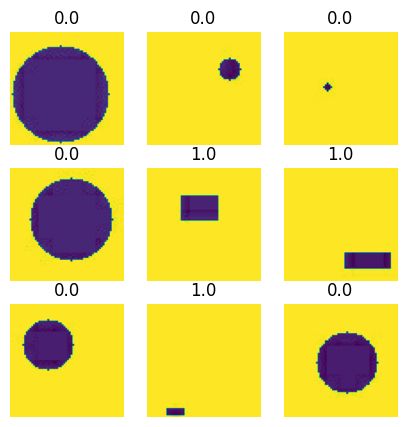

In [165]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(labels[i].numpy()[0])
        plt.axis("off")

In [166]:
for image_batch, labels_batch in train_ds:
    print('Image batch shape: ', image_batch.shape)
    print('Labels batch shape: ', labels_batch.shape)
    break

Image batch shape:  (32, 64, 64, 1)
Labels batch shape:  (32, 1)


### Buffer prefetching

In [167]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model definition and training

#### helpers

In [200]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

def printScores(y_pred, y_true):
    print("Classification report:")
    print(classification_report(y_true, y_pred))
    print("Confusion matrix:")
    print(confusion_matrix(y_true, y_pred))
    
def plotTrainingHistory(model):

    fig, axes= plt.subplots(1,2,figsize=(10,5))
    history = model.history
    axes[0].plot(history['accuracy'])
    axes[0].plot(history['val_accuracy'])
    axes[0].set_ylabel('accuracy')
    axes[0].set_xlabel('epoch')
    axes[0].legend(['train', 'validation'], loc='upper left')

    axes[1].plot(history['loss'])
    axes[1].plot(history['val_loss'])
    axes[1].set_ylabel('loss')
    axes[1].set_xlabel('epoch')
    axes[1].legend(['train', 'validation'], loc='upper left')

### class-defined model

In [169]:
def CNN_class(nFilters, kernel_size, pool_size, nNeurons, inputShape, outputWidth):
    inputs = tf.keras.Input(shape=inputShape)
    x = inputs
    x = tf.keras.layers.Rescaling(1./255, input_shape=inputShape)(x)
    x = tf.keras.layers.Conv2D(nFilters, kernel_size=kernel_size)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(x)
    x = tf.keras.layers.Conv2D(nFilters, kernel_size=kernel_size)(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=pool_size)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(nNeurons, activation=tf.nn.relu)(x)
    x = tf.keras.layers.Dense(int(nNeurons / 2), activation=tf.nn.relu)(x)
    x = tf.keras.layers.Dense(int(nNeurons / 2), activation=tf.nn.relu)(x)
    outputs = tf.keras.layers.Dense(outputWidth, activation=tf.nn.softmax)(x)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
    return model

### model training

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_11 (InputLayer)       [(None, 64, 64, 1)]       0         
                                                                 
 rescaling_12 (Rescaling)    (None, 64, 64, 1)         0         
                                                                 
 conv2d_32 (Conv2D)          (None, 62, 62, 32)        320       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 20, 20, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 18, 18, 32)        9248      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 6, 6, 32)         0         
 g2D)                                                      

D:\projekty\mgr\custom_nn\mgr-env\lib\site-packages\keras\backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


63/63 [==============================] - 2s 20ms/step - loss: 0.6022 - accuracy: 0.6575 - val_loss: 0.5677 - val_accuracy: 0.7150
Epoch 2/15
63/63 [==============================] - 1s 15ms/step - loss: 0.5274 - accuracy: 0.7405 - val_loss: 0.5099 - val_accuracy: 0.7150
Epoch 3/15
63/63 [==============================] - 1s 16ms/step - loss: 0.4878 - accuracy: 0.7590 - val_loss: 0.4822 - val_accuracy: 0.7800
Epoch 4/15
63/63 [==============================] - 1s 17ms/step - loss: 0.4497 - accuracy: 0.7785 - val_loss: 0.4438 - val_accuracy: 0.7700
Epoch 5/15
63/63 [==============================] - 1s 18ms/step - loss: 0.3770 - accuracy: 0.8310 - val_loss: 0.3852 - val_accuracy: 0.8600
Epoch 6/15
63/63 [==============================] - 1s 19ms/step - loss: 0.2622 - accuracy: 0.8895 - val_loss: 0.2243 - val_accuracy: 0.9050
Epoch 7/15
63/63 [==============================] - 1s 19ms/step - loss: 0.1681 - accuracy: 0.9370 - val_loss: 0.1748 - val_accuracy: 0.9200
Epoch 8/15
63/63 [======

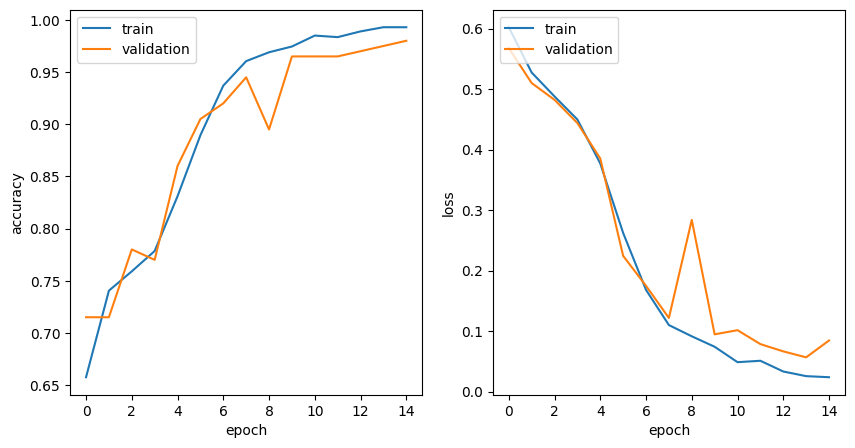

In [170]:
%%time 

batch_size = 32
nFilters = 32
kernel_size = 3
pool_size = (3,3)
nNeurons = 128 
nHiddenLayers = 1 
inputShape = (64, 64, 1)
outputWidth = 2

epochs = 15

model = CNN_class(nFilters, kernel_size, pool_size, nNeurons, inputShape, outputWidth)
model.summary()
model_fit = model.fit(train_ds, validation_data = val_ds, epochs=epochs) 

plotTrainingHistory(model_fit)

### testing on test dataset

In [173]:
import glob

test = glob.glob('../data/test/*/*')

In [191]:
def test_predict(data_dir):
    predictions = []
    for path in data_dir:
        img = tf.keras.utils.load_img(path, color_mode='grayscale')
        img_array = tf.keras.utils.img_to_array(img)
        img_array = tf.expand_dims(img_array, 0) # Create a batch
        y = np.argmax(model.predict(img_array, verbose = 0))
        predictions.append(y)
                  
    return predictions

In [196]:
y_pred = test_predict(test)

In [201]:
printScores(y_test_list, y_pred)

Classification report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97       293
           1       0.99      0.96      0.98       307

    accuracy                           0.97       600
   macro avg       0.98      0.98      0.97       600
weighted avg       0.98      0.97      0.98       600

Confusion matrix:
[[289   4]
 [ 11 296]]
